## Notes 
### Required installing Oracle JAVA 8 to get javabridge installed
### Then, I was able to install py-causal from https://bd2kccd.github.io/docs/py-causal/
### GFCI is slower than RFCI, but more accurate (SPIRTES), GFCI and RFCI account for unobserved variables, FGES assumes no unobserved variables.

Structure Learning Performance Guarantees If the assumptions in the previous section hold, then in the large sample limit, the CBN structure output by GFCId will contain an edge of one of four kinds between Xand Y   if and only if Xand Yare not independent conditional on any subset of the other measured variables of less than or equal to a specified size. In addition, there is (1) an arc X->Y   if and only if Xdirectly or indirectly causes Y, and Y   does not directly or indirectly cause X; (2) an edge X <-->Y   if and only if X   is not a direct or indirect cause of Yand Y   is not a direct or indirect cause of X(which can only occur if there are latent confounders of Xand some other variable or Yand some other variable; (3) an edge Xo->Y   only if Yis not a direct or indirect cause of X, but Xmay or may not be an indirect cause of Y; (4) an edge X o–o Y   indicates that Xand Y   are dependent no matter what subset of observed variables is conditioned on, but contains no orientation information (X   may be a direct or indirect cause of Y, and Ymay be an indirect cause of X, or there may be a latent common cause of Xand Y.

# Trying some various ML models

In [1]:
import configparser
import random
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score, average_precision_score
from keras.models import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, Callback
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import load_model, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, \
                        Input, Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.utils import to_categorical
from collections import Counter
import keras.optimizers
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
import glob, os
import tensorflow as tf
import pandas as pd
from random import shuffle

# select your GPU Here
os.environ["CUDA_VISIBLE_DEVICES"]="0" #Comment this line out if you want all GPUS (2 hehe)

# python full-display web browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


def get_model(dense, dropouts, inputs):
    # dense is an ordered list of the number of dense neurons like [1024, 2048, 1024]
    # dropouts is an ordered list of the dropout masks like [0.2, 0.3, 0.4]
    inputs = keras.Input(shape = (inputs,))

    x = keras.layers.Dense(dense[0], activation = 'relu')(inputs)
    x = keras.layers.Dropout(dropouts[0])(x, training=True)
    for den, drop in zip(dense[1:], dropouts[1:]):
        x = keras.layers.Dense(den, activation = 'relu')(x)
        x = keras.layers.Dropout(drop)(x, training=True)
    outputs = keras.layers.Dense(1, activation = 'linear')(x)
    model = keras.Model(inputs, outputs)
    return model


/home/tkyono/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_auc_score, average_precision_score, mean_squared_error, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import pandas as pd
from pycausal import search as s




def discrete_gauss(low, high, samples, std = 20):
    x = np.arange(low, high)
    xU, xL = x + 0.5, x - 0.5 
    prob = ss.norm.cdf(xU, scale = std) - ss.norm.cdf(xL, scale = std)
    prob = prob / prob.sum() #normalize the probabilities so their sum is 1
    nums = np.random.choice(x, size = samples, p = prob)
    return nums



def bar_plot(x_ax, val1, val1std, val2, val2std):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ## the data
    N = len(x_ax)

    ## necessary variables
    ind = np.arange(N)                # the x locations for the groups
    width = 0.35                      # the width of the bars
    fig.set_size_inches(18.5, 10.5)
    ## the bars
    rects1 = ax.bar(ind, val1, width,
                    color='gray',
                    yerr=val1std,
                    error_kw=dict(elinewidth=2,ecolor='blue'))

    rects2 = ax.bar(ind+width, val2, width,
                        color='blue',
                        #yerr=val2std,
                        error_kw=dict(elinewidth=2,ecolor='gray'))

    # axes and labels
    ax.set_xlim(-width,len(ind)+width)
    #ax.set_ylim(0,45)
    ax.set_ylabel('Percentage')
    ax.set_title('')
    plt.xticks(ind + width / 2, x_ax, rotation=75, size = 14)
    ## add a legend
    ax.legend( (rects1[0], rects2[0]), ('Accuracy', '% Violations') )
    fig.savefig("violations.pdf", bbox_inches='tight')
    plt.show()





def gen_data(mean = 0, var = 1, SIZE = 5000):
    a = np.random.gumbel(mean, var, SIZE)
    b = np.random.gumbel(mean, var, SIZE)
    c = np.random.gumbel(mean, var, SIZE)
    d = np.random.gumbel(mean, var, SIZE)
    e = np.random.gumbel(mean, var, SIZE)
    f= a + b + c + d + e + np.random.gumbel(mean, var, SIZE)
    g = f + np.random.gumbel(mean,var, SIZE)
    g = np.rint(g)
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})

def gen_data(mean = 0, var = 1, SIZE = 5000):
    a = np.random.gumbel(mean, var, SIZE)
    b = np.random.gumbel(mean, var, SIZE)
    c = np.random.gumbel(mean, var, SIZE)
    d = np.random.gumbel(mean, var, SIZE)

    f= a + b + c + d + np.random.gumbel(mean, var, SIZE)
    g = f + np.random.gumbel(mean,var, SIZE)
    
    
    g = np.rint(g)
    e = g + np.random.gumbel(mean,var,SIZE)
    
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})


def gen_data(mean = 0, var = 1, SIZE = 400000):
    f = np.random.normal(mean, var, SIZE)
    a = f + np.random.normal(mean, var, SIZE)
    b = f + np.random.normal(mean, var, SIZE)
    c = f + np.random.normal(mean, var, SIZE)
    d = f + np.random.normal(mean, var, SIZE)
    e = f + np.random.normal(mean, var, SIZE)
    g = a + b + c + d  + e + np.random.normal(mean, var, SIZE)

    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})

def gen_data(mean = 0, var = 2, SIZE = 500000):
    a = np.random.normal(mean, var, SIZE)
    b = np.random.normal(mean, var, SIZE)
    c = np.random.normal(mean, var, SIZE)
    d = np.random.normal(mean, var, SIZE)
    e = np.random.normal(mean, var, SIZE)
    f= a + b + c + d + e + np.random.normal(mean, var, SIZE)
    g = f + np.random.normal(mean,var, SIZE)
    #g = np.rint(g)
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})



def get_CG(df, tetrad):
    tetrad.run(algoId = 'gfci', dfs = df, testId = 'sem-bic', scoreId = 'sem-bic', dataType = 'continuous',
           structurePrior = 1.0, samplePrior = 1.0, maxDegree = -1, maxPathLength = -1, 
           completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True)
    #tetrad.run(algoId = 'gfci', dfs = df, testId = 'bdeu', scoreId = 'bdeu', dataType = 'discrete',
    #       structurePrior = 1.0, samplePrior = 1.0, maxDegree = 3, faithfulnessAssumed = True, verbose = True)


    return tetrad.getTetradGraph()

def get_MB(graph, var, pc):
    parents = set()
    children = set()
    for i in pc.extractTetradGraphEdges(graph):
        if i[-1] == var and i[3:5] == '->':
            parents.add(i[0])
        if i[0] == var and i[3:5] == '->':
            children.add(i[-1])
    return parents, children

from pycausal.pycausal import pycausal as pc
from collections import defaultdict
pc = pc()
pc.start_vm(java_max_heap_size = '5000M')
tetrad = s.tetradrunner()






verbosity = 1


models = [#[8,8,4],
          #[16,16,8],
          #LogisticRegression(), 
          #Perceptron(),  
          #DecisionTreeClassifier(),
          #LinearSVC(),
          #GaussianNB(),
          #[32,32,16],
          #[64,64,32],
          #[128, 128, 64],
          #[256, 256, 128],
          #[512, 512, 256],
          #[1024, 1024, 512],
          [2048, 2048, 2048, 1024],[2048, 2048, 2048, 1024],[2048, 2048, 2048, 1024], 
            [2048, 2048, 2048, 1024],[2048, 2048, 2048, 1024],[2048, 2048, 2048, 1024],
            [2048, 2048, 2048, 1024],[2048, 2048, 2048, 1024],[2048, 2048, 2048, 1024],
          #[2048, 2048, 1024],
         ]
model_names = ['m1', 
               'm2',
               'm3',
                'm4', 
               'm5',
               'm6',
                'm7', 
               'm8',
               'm9',

               #'m7', 
               #'m8',
               #'m9',
               #'m10', 
               #'m11a',
               #'m11b',
               #'m11c',
              ]






df = gen_data()
X = df[['a', 'b', 'c', 'd', 'e', 'f']].values
y = df['g'].values

val_df = gen_data()
x_val = df[['a', 'b', 'c', 'd', 'e', 'f']].values
y_val = df['g'].values


model_list = []





In [3]:
for idx, model_name in enumerate(model_names):
    print(model_name)

    if type(models[idx]) is list:
        #clear session
        keras.backend.clear_session() 
        #get model according to specification
        model = get_model(models[idx], [0.2] * len(models), 6)
        callbacks = [ModelCheckpoint(model_name, verbose= verbosity, monitor='val_loss',save_best_only=True), 
                     EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, verbose= verbosity, mode='auto')]
        model.compile(optimizer = optimizers.SGD(lr = 0.001, momentum = 0.9, ), loss='mean_squared_error', metrics = ['mse'])
        #print(len(X), len(y))
        model.fit(X, y, epochs = 20, validation_data = (x_val, y_val), callbacks = callbacks, batch_size = 32, verbose = verbosity)
    else:
        models[idx].fit(X,y)


m1
Train on 500000 samples, validate on 500000 samples
Epoch 1/20
500000/500000 [==============================] - 92s 184us/step - loss: 4.3672 - mean_squared_error: 4.3672 - val_loss: 4.1440 - val_mean_squared_error: 4.1440

Epoch 00001: val_loss improved from inf to 4.14400, saving model to m1
Epoch 2/20
500000/500000 [==============================] - 92s 184us/step - loss: 4.3042 - mean_squared_error: 4.3042 - val_loss: 4.1568 - val_mean_squared_error: 4.1568

Epoch 00002: val_loss did not improve from 4.14400
Epoch 3/20
500000/500000 [==============================] - 92s 184us/step - loss: 4.2821 - mean_squared_error: 4.2821 - val_loss: 4.3919 - val_mean_squared_error: 4.3919

Epoch 00003: val_loss did not improve from 4.14400
Epoch 4/20
500000/500000 [==============================] - 92s 185us/step - loss: 4.2597 - mean_squared_error: 4.2597 - val_loss: 4.1337 - val_mean_squared_error: 4.1337

Epoch 00004: val_loss improved from 4.14400 to 4.13370, saving model to m1
Epoch 5/2


Epoch 00003: val_loss improved from 4.29316 to 4.16239, saving model to m5
Epoch 4/20
500000/500000 [==============================] - 97s 194us/step - loss: 4.2579 - mean_squared_error: 4.2579 - val_loss: 4.1271 - val_mean_squared_error: 4.1271

Epoch 00004: val_loss improved from 4.16239 to 4.12714, saving model to m5
Epoch 5/20
500000/500000 [==============================] - 97s 195us/step - loss: 4.2395 - mean_squared_error: 4.2395 - val_loss: 4.1852 - val_mean_squared_error: 4.1852

Epoch 00005: val_loss did not improve from 4.12714
Epoch 6/20
500000/500000 [==============================] - 97s 194us/step - loss: 4.2246 - mean_squared_error: 4.2246 - val_loss: 4.1294 - val_mean_squared_error: 4.1294

Epoch 00006: val_loss did not improve from 4.12714
Epoch 7/20
500000/500000 [==============================] - 97s 194us/step - loss: 4.2118 - mean_squared_error: 4.2118 - val_loss: 4.1137 - val_mean_squared_error: 4.1137

Epoch 00007: val_loss improved from 4.12714 to 4.11371, sav

Train on 500000 samples, validate on 500000 samples
Epoch 1/20
500000/500000 [==============================] - 97s 194us/step - loss: 4.3586 - mean_squared_error: 4.3586 - val_loss: 4.1331 - val_mean_squared_error: 4.1331

Epoch 00001: val_loss improved from inf to 4.13312, saving model to m9
Epoch 2/20
500000/500000 [==============================] - 97s 194us/step - loss: 4.3028 - mean_squared_error: 4.3028 - val_loss: 4.1493 - val_mean_squared_error: 4.1493

Epoch 00002: val_loss did not improve from 4.13312
Epoch 3/20
500000/500000 [==============================] - 94s 187us/step - loss: 4.2839 - mean_squared_error: 4.2839 - val_loss: 4.2587 - val_mean_squared_error: 4.2587

Epoch 00003: val_loss did not improve from 4.13312
Epoch 4/20
500000/500000 [==============================] - 92s 185us/step - loss: 4.2590 - mean_squared_error: 4.2590 - val_loss: 4.2286 - val_mean_squared_error: 4.2286

Epoch 00004: val_loss did not improve from 4.13312
Epoch 00004: early stopping


In [5]:
metrics_dicts = []
for m in models:
    metrics_dicts.append(defaultdict(list))


#means = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
#variances = [1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
means = [0,1,2,3,4]
variances = [1, 2,3,4,5]


# ok at this point we need to check the model on various variances and means
for m in means:
    for v in variances:
        print(m,v)
        #t0 = time.time()
        perturbed_df = gen_data(mean =m, var = v, SIZE = nb_test)
        y_test2 = perturbed_df['g']
        x_test2 = perturbed_df[['a', 'b', 'c', 'd', 'e', 'f']]
        #t1 = time.time()
        #print("Time for gen_data = ", t1 - t0)
        for idx, model_name in enumerate(model_names):
            #t0 = time.time()
            if type(models[idx]) is list:
                keras.backend.clear_session()
                model = load_model(model_name)
            else:
                model = models[idx]
            #t1 = time.time()
            #print("Time to load model = ", t1 - t0)
            
            y_pred2 = model.predict(x_test2)
            metrics_dicts[idx][str(m) + '_' + str(v)].append(mean_squared_error(y_test2, y_pred2))

            test_df2 = pd.DataFrame(x_test2, columns = ['a', 'b', 'c', 'd', 'e', 'f'])
            test_targets2 = pd.DataFrame(model.predict(x_test2), columns = ['g'])
            test_df2 = test_df2.join(test_targets2)
'''
            setA = get_MB(get_CG(perturbed_df, tetrad), 'g', pc)
            if setA != {'f'}:
                print("Error in SETA markov blanket")
                #setA = {'f'}
            setC = get_MB(get_CG(test_df2, tetrad), 'g', pc)

            if setA != setC:
                causal_dicts[idx][str(m) + '_' + str(v)].append(1)
            else:
                causal_dicts[idx][str(m) + '_' + str(v)].append(0)

'''



print("Violations = ", violations)



0 1
0 2
0 3
0 4
0 5
1 1
1 2
1 3
1 4
1 5
2 1
2 2
2 3
2 4
2 5
3 1
3 2
3 3
3 4
3 5
4 1
4 2
4 3
4 4
4 5
Violations =  [25. 25. 25. 25. 25. 25. 21. 25. 25.]


In [16]:
#the number of times to sample 
times = 10

## the size of the test set
nb_test = 2000

violations = np.zeros(len(models))
violation_mean = np.zeros((len(models), times))
violation_mean2 = np.zeros((len(models), times))
mean = np.zeros((len(models), times))

fold = 0

#metrics_dicts = []
causal_dicts = []
for m in models:
#    metrics_dicts.append(defaultdict(list))
    causal_dicts.append(defaultdict(list))



for t in range(times):
    print("Times = ", t)
    df_test = gen_data(SIZE = nb_test)
    x_test = df_test[['a', 'b', 'c', 'd', 'e', 'f']].values
    y_test = df_test['g'].values
    setAp, setAc = get_MB(get_CG(df_test, tetrad), 'g', pc)
    setA = set(tetrad.getEdges())
    #print("BIC1 = ", tetrad.getTetradGraph().toString().split('BIC')[-1])

    for idx, model_name in enumerate(model_names):
        if type(models[idx]) is list:
            keras.backend.clear_session()
            model = load_model(model_name)
        else:
            model = models[idx]
        test_df = pd.DataFrame(x_test, columns = ['a', 'b', 'c', 'd', 'e', 'f'])
        test_targets = pd.DataFrame(model.predict(x_test), columns = ['g'])
        test_df = test_df.join(test_targets)
        mean[idx][t] = mean_squared_error(y_test, model.predict(x_test))  
        #print(mean_squared_error(y_test, model.predict(x_test)))


        setBp, setBc = get_MB(get_CG(test_df, tetrad), 'g', pc)
        setB = set(tetrad.getEdges())
        #print("BIC2 = ", tetrad.getTetradGraph().toString().split('BIC')[-1])
        print(setAp, setAc, setBp, setBc)
        if setAp != {'f'}:
            print("Error in SETAp markov blanket")
            #setA = {'f'}
        print(setAp, setAc, setBp, setBc)
        
        print("Set violations = ", len(setA.difference(setB)) + len(setB.difference(setA)))
        print("Violations = ",len(setAp.difference(setBp)) + len(setBp.difference(setAp)) + len(setAc.difference(setBc)) + len(setBc.difference(setAc)))
        violation_mean[idx][t] = len(setAp.difference(setBp)) + len(setBp.difference(setAp)) + len(setAc.difference(setBc)) + len(setBc.difference(setAc))
        violation_mean2[idx][t] = len(setA.difference(setB)) + len(setB.difference(setA))
        if setAp != setBp or setAc != setBc:
            #print("Violation:", model_names[idx], setA , setB)
            violations[idx] += 1

            


Times =  0
{'f'} set() {'e', 'c', 'a', 'd'} {'f'}
{'f'} set() {'e', 'c', 'a', 'd'} {'f'}
Set violations =  10
Violations =  6
{'f'} set() {'c', 'a', 'd'} {'f'}
{'f'} set() {'c', 'a', 'd'} {'f'}
Set violations =  9
Violations =  5
{'f'} set() {'e', 'f', 'b'} set()
{'f'} set() {'e', 'f', 'b'} set()
Set violations =  4
Violations =  2
{'f'} set() {'f'} set()
{'f'} set() {'f'} set()
Set violations =  0
Violations =  0
{'f'} set() {'f', 'a'} set()
{'f'} set() {'f', 'a'} set()
Set violations =  1
Violations =  1
{'f'} set() {'f', 'b'} set()
{'f'} set() {'f', 'b'} set()
Set violations =  2
Violations =  1
{'f'} set() {'b', 'e', 'c', 'a', 'd'} {'f'}
{'f'} set() {'b', 'e', 'c', 'a', 'd'} {'f'}
Set violations =  12
Violations =  7
{'f'} set() {'b', 'e', 'c', 'a', 'd'} {'f'}
{'f'} set() {'b', 'e', 'c', 'a', 'd'} {'f'}
Set violations =  12
Violations =  7
{'f'} set() {'c', 'a', 'd'} {'f'}
{'f'} set() {'c', 'a', 'd'} {'f'}
Set violations =  9
Violations =  5
Times =  1
{'f'} set() {'e', 'c', 'a', '

{'f'} set() {'b', 'e', 'c', 'a', 'd'} {'f'}
{'f'} set() {'b', 'e', 'c', 'a', 'd'} {'f'}
Set violations =  12
Violations =  7
{'f'} set() set() {'f'}
{'f'} set() set() {'f'}
Set violations =  7
Violations =  2
Times =  9
{'f'} set() {'e', 'c', 'a', 'd'} {'f'}
{'f'} set() {'e', 'c', 'a', 'd'} {'f'}
Set violations =  10
Violations =  6
{'f'} set() {'e', 'c', 'a', 'd'} {'f'}
{'f'} set() {'e', 'c', 'a', 'd'} {'f'}
Set violations =  10
Violations =  6
{'f'} set() {'e', 'c', 'a', 'b'} {'f'}
{'f'} set() {'e', 'c', 'a', 'b'} {'f'}
Set violations =  10
Violations =  6
{'f'} set() {'f', 'a'} set()
{'f'} set() {'f', 'a'} set()
Set violations =  2
Violations =  1
{'f'} set() {'e', 'c', 'd', 'b'} {'f'}
{'f'} set() {'e', 'c', 'd', 'b'} {'f'}
Set violations =  10
Violations =  6
{'f'} set() {'e', 'c', 'a', 'b'} {'f'}
{'f'} set() {'e', 'c', 'a', 'b'} {'f'}
Set violations =  10
Violations =  6
{'f'} set() {'f', 'd'} set()
{'f'} set() {'f', 'd'} set()
Set violations =  2
Violations =  1
{'f'} set() {'b',

Model_name =  m1 Violations =  10.0
Average_violations =  3.5 2.5
MSE =  4.170568824720625 0.14374873140695027
Model_name =  m2 Violations =  5.0
Average_violations =  2.9 2.9137604568666933
MSE =  4.170657208623488 0.1380687458621909
Model_name =  m3 Violations =  10.0
Average_violations =  4.9 1.7578395831246945
MSE =  4.209876389322074 0.1354541158389074
Model_name =  m4 Violations =  4.0
Average_violations =  1.9 2.6999999999999997
MSE =  4.139994279053636 0.13489574148907627
Model_name =  m5 Violations =  10.0
Average_violations =  4.7 2.0024984394500787
MSE =  4.169392871924362 0.1309107847070299
Model_name =  m6 Violations =  10.0
Average_violations =  4.0 2.449489742783178
MSE =  4.193767177451504 0.1466392699490749
Model_name =  m7 Violations =  10.0
Average_violations =  2.7 2.6095976701399777
MSE =  4.14019529221721 0.1252361563700851
Model_name =  m8 Violations =  7.0
Average_violations =  4.9 3.207802986469088
MSE =  4.172566364958849 0.14774924910520026
Model_name =  m9 V

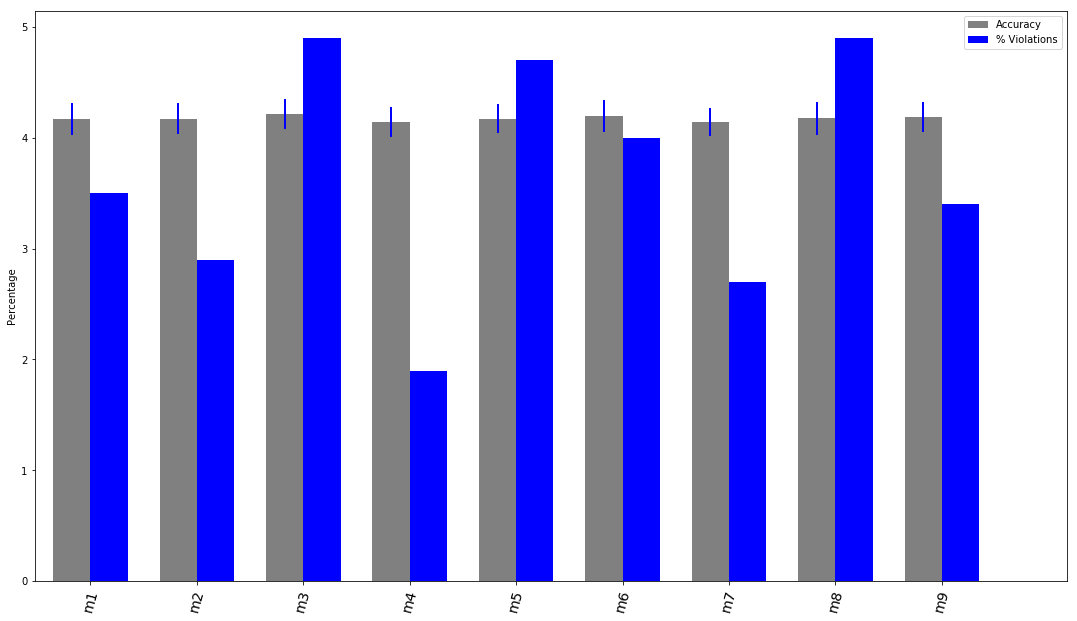

m1
Area under surface (rectangular approx) =  470.9209908250812
Violations =  10.0
Average_violations =  3.5
MSE =  4.170568824720625


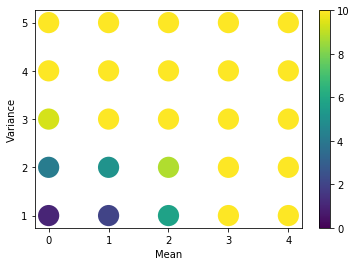

m2
Area under surface (rectangular approx) =  573.7238524930711
Violations =  5.0
Average_violations =  2.9
MSE =  4.170657208623488


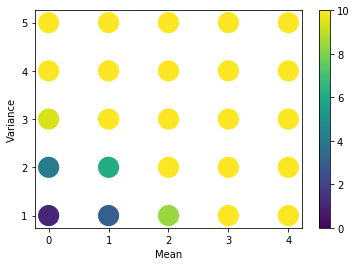

m3
Area under surface (rectangular approx) =  421.32513182565526
Violations =  10.0
Average_violations =  4.9
MSE =  4.209876389322074


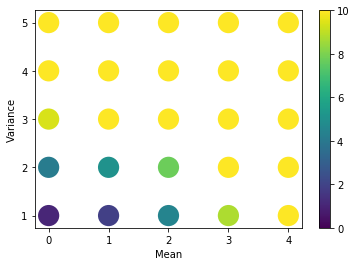

m4
Area under surface (rectangular approx) =  455.71422988582987
Violations =  4.0
Average_violations =  1.9
MSE =  4.139994279053636


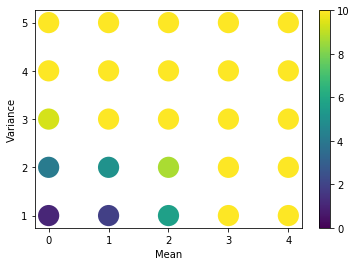

m5
Area under surface (rectangular approx) =  511.516311529412
Violations =  10.0
Average_violations =  4.7
MSE =  4.169392871924362


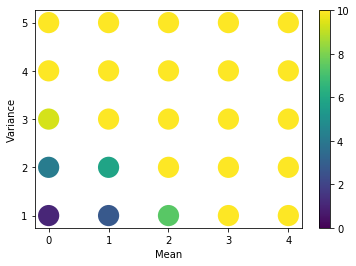

m6
Area under surface (rectangular approx) =  470.1084112176025
Violations =  10.0
Average_violations =  4.0
MSE =  4.193767177451504


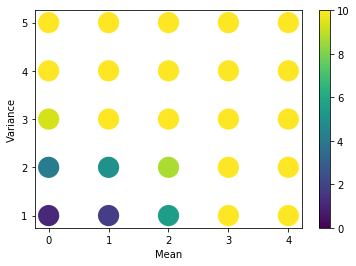

m7
Area under surface (rectangular approx) =  448.8838117129145
Violations =  10.0
Average_violations =  2.7
MSE =  4.14019529221721


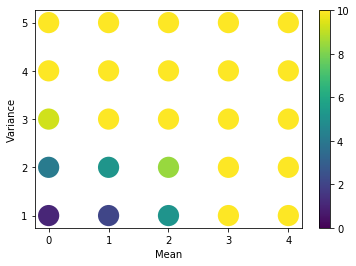

m8
Area under surface (rectangular approx) =  399.9596346682041
Violations =  7.0
Average_violations =  4.9
MSE =  4.172566364958849


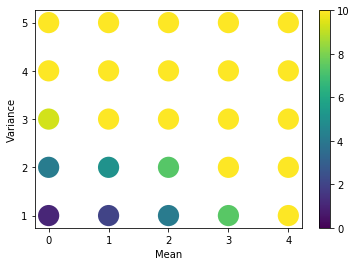

m9
Area under surface (rectangular approx) =  556.1011787559178
Violations =  10.0
Average_violations =  3.4
MSE =  4.188116054027455


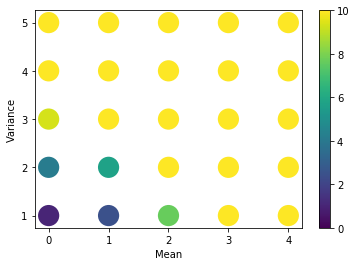

In [17]:
metric = []
metric_err = []
viol = []
viol_err = []

#normalize the violations for prettier graphing.
#also violations are always positive, so just divide by max.

#TMK
#violation_mean = violation_mean / np.max(violation_mean)

for i in range(len(violations)):
    print("Model_name = ", model_names[i], "Violations = ", violations[i])
    print("Average_violations = ", np.mean(violation_mean[i]), np.std(violation_mean[i]))
    print("MSE = ", np.mean(mean[i]), np.std(mean[i]))
    #print("mean = ", mean[i])
    metric.append(np.mean(mean[i]))
    metric_err.append(np.std(mean[i]))
    viol.append(np.mean(violation_mean[i]))
    #viol.append(violations[i]/times)
    viol_err.append(np.std(violation_mean[i]))
print(np.array(metric), 
         np.array(metric_err), 
         np.array(viol), 
         np.array(viol_err))    

bar_plot(model_names, 
         np.array(metric), 
         np.array(metric_err), 
         np.array(viol), 
         np.array(viol_err))


def heat_plot(x,y,z, xlab = 'Mean', ylab = 'Variance', clim_low = 0, clim_high = 1):
    fig, ax = plt.subplots()

    cax = ax.scatter(x, y, c=z, s=450, edgecolor='')
    cax.set_clim(clim_low, clim_high)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    plt.colorbar(cax)
    plt.show()

    
MSE = []
VIO = []
VIO2 = []
AUS = []
for i, m in enumerate(models):
    print(model_names[i])
    x = []
    y = []
    z = []
    
    
    rectangular_approx = 0
    for k, v in metrics_dicts[i].items():
        x.append(float(k.split('_')[0]))
        y.append(float(k.split('_')[-1]))
        z.append(np.mean(v))
        rectangular_approx += np.mean(v)
    print("Area under surface (rectangular approx) = ", rectangular_approx)
    print("Violations = ", violations[i])
    print("Average_violations = ", np.mean(violation_mean[i]))
    print("MSE = ", np.mean(mean[i]))   
    MSE.append(np.mean(mean[i]))
    VIO.append(np.mean(violation_mean[i]))
    VIO2.append(np.mean(violation_mean2[i]))
    #VIO.append(violations[i]/times)
    AUS.append(rectangular_approx)
    
    heat_plot(x,y,z, clim_low = 0, clim_high = 10)
    
#heat_plot(MSE,VIO,AUS, xlab = 'MSE', ylab='Violations', clim_low = np.min(AUS), clim_high = np.max(AUS))
    


543.7910618447934 -17.80747731578875


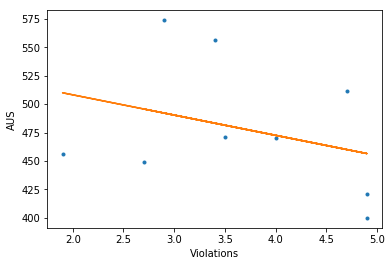

543.8563569639929 -10.39811453479159


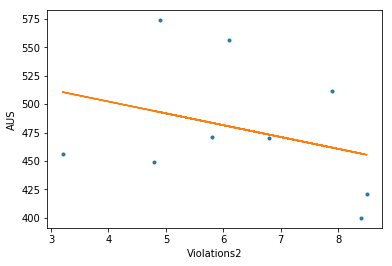

4.11719307427301 0.015209628992162338


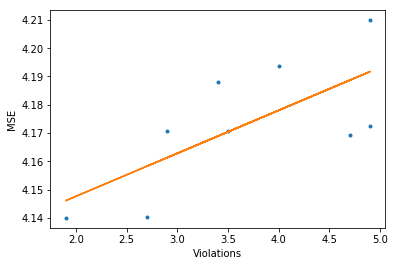

AUS vs Violation 1


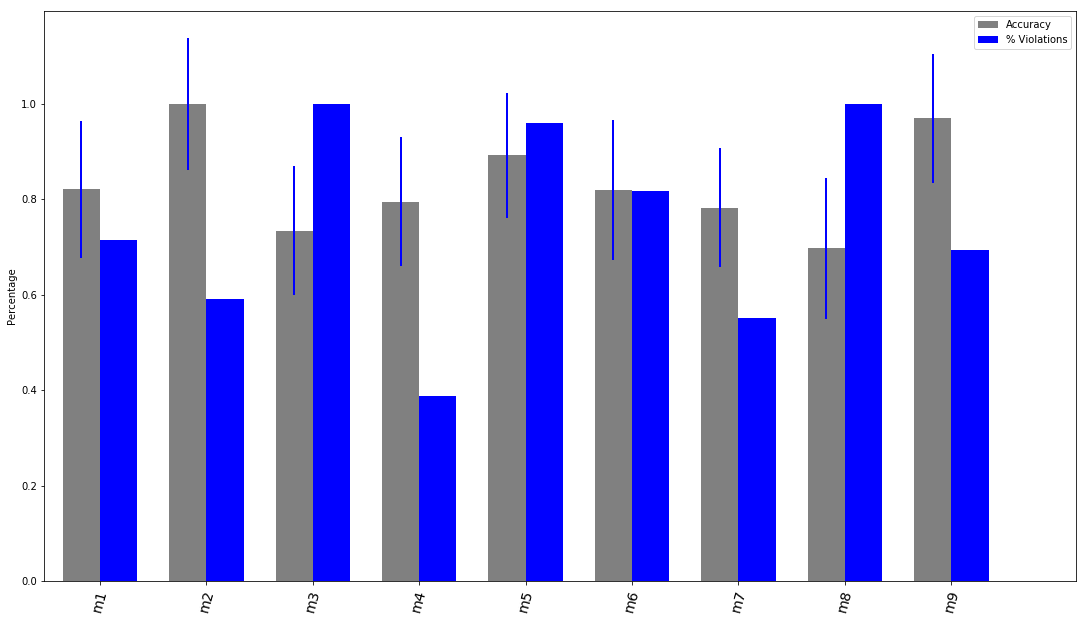

AUS vs Violation 2


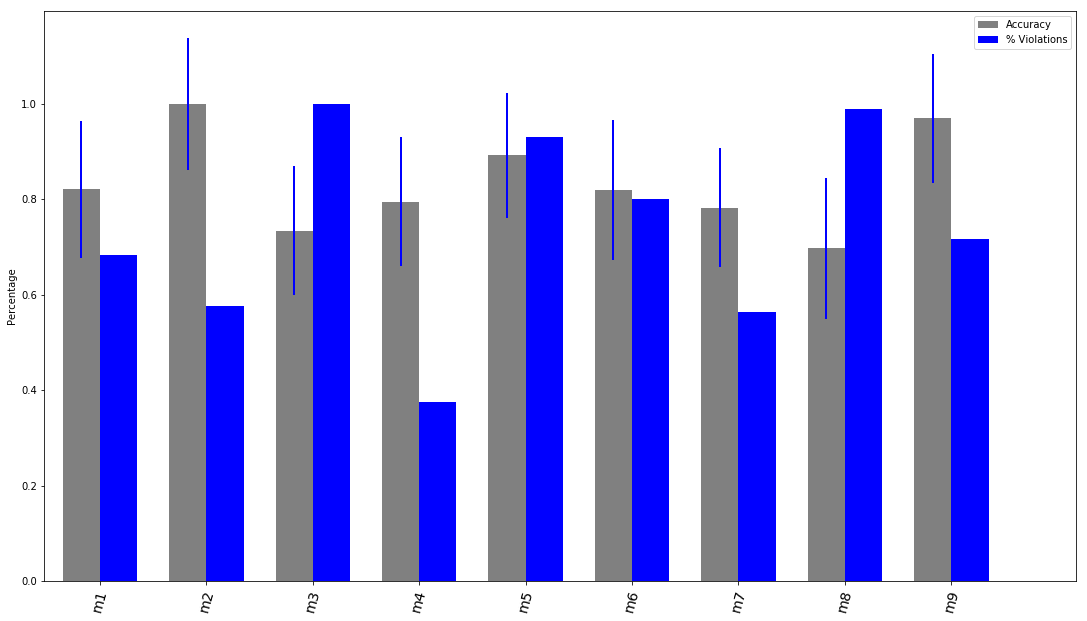

Violations vs Violation2


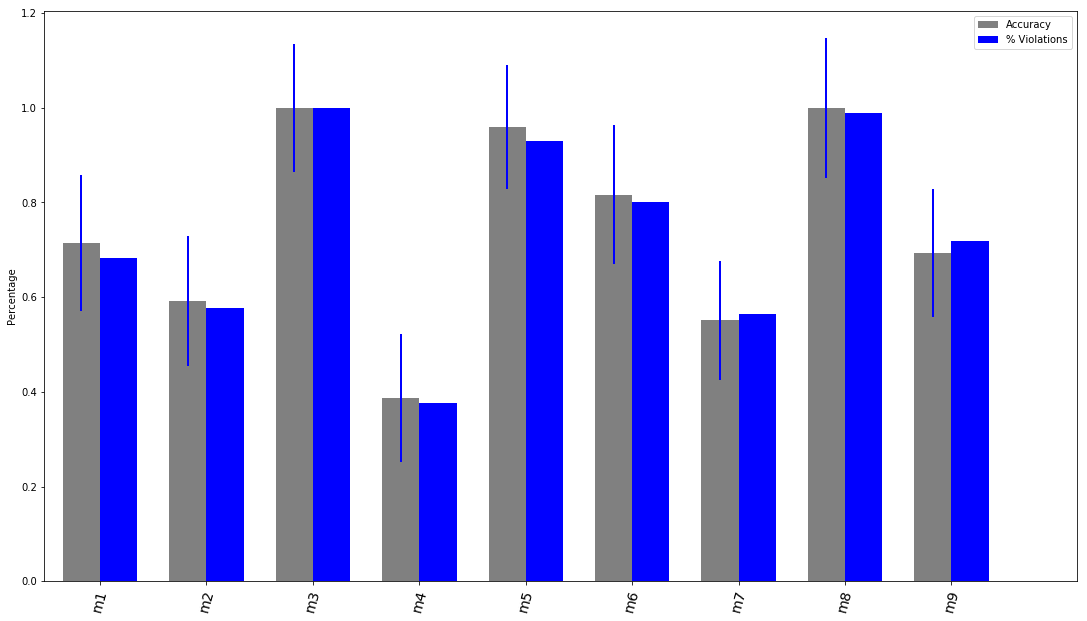

Low Violations =  501.0688127345629 for 5
High Violations =  450.72737231021847 for 4
Low MSE =  4.161906331728483 for 5
High MSE =  4.186400700914197 for 4


In [18]:
from numpy.polynomial.polynomial import polyfit  
fig, ax = plt.subplots()
b,m = polyfit(VIO,AUS, 1)
print(b,m)
ax.plot(VIO,AUS, '.')

plt.plot(VIO, b + m * np.array(VIO), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("Violations")
ax.set_ylabel("AUS")
plt.show()


fig, ax = plt.subplots()
b,m = polyfit(VIO2,AUS, 1)
print(b,m)
ax.plot(VIO2,AUS, '.')
plt.plot(VIO2, b + m * np.array(VIO2), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("Violations2")
ax.set_ylabel("AUS")
plt.show()


fig, ax = plt.subplots()
b,m = polyfit(VIO,MSE, 1)
print(b,m)
ax.plot(VIO,MSE, '.')

plt.plot(VIO, b + m * np.array(VIO), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("Violations")
ax.set_ylabel("MSE")
plt.show()

print("AUS vs Violation 1")
bar_plot(model_names, 
         np.array(AUS/np.max(AUS)), 
         np.array(metric_err), 
         np.array(VIO/np.max(VIO)), 
         np.array(viol_err))

print("AUS vs Violation 2")
bar_plot(model_names, 
         np.array(AUS/np.max(AUS)), 
         np.array(metric_err), 
         np.array(VIO2/np.max(VIO2)), 
         np.array(viol_err))

print("Violations vs Violation2")
bar_plot(model_names, 
         np.array(VIO/np.max(VIO)), 
         np.array(metric_err), 
         np.array(VIO2/np.max(VIO2)), 
         np.array(viol_err))

low = []
low_mse = []
high = []
high_mse = []
for i, vio in enumerate(VIO2):
    if vio < np.mean(VIO2):
        low.append(AUS[i])
        low_mse.append(MSE[i])
    else:
        high.append(AUS[i])
        high_mse.append(MSE[i])
print("Low Violations = ", np.mean(low), "for", len(low))
print("High Violations = ", np.mean(high), "for", len(high))
print("Low MSE = ", np.mean(low_mse), "for", len(low_mse))
print("High MSE = ", np.mean(high_mse), "for", len(high_mse))

In [19]:
low = []
low_mse = []
high = []
high_mse = []
for i, vio in enumerate(VIO):
    if vio < np.mean(VIO):
        low.append(AUS[i])
        low_mse.append(MSE[i])
    else:
        high.append(AUS[i])
        high_mse.append(MSE[i])
print("Low Violations = ", np.mean(low), "for", len(low))
print("High Violations = ", np.mean(high), "for", len(high))
print("Low MSE = ", np.mean(low_mse), "for", len(low_mse))
print("High MSE = ", np.mean(high_mse), "for", len(high_mse))

Low Violations =  501.0688127345629 for 5
High Violations =  450.72737231021847 for 4
Low MSE =  4.161906331728483 for 5
High MSE =  4.186400700914197 for 4
